In [1]:
!pip install scikit-optimize
!pip install ipython-autotime
!pip install tensorflow keras-tuner

%load_ext autotime

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 36.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 3.7 MB/s eta 0:00:00
time: 275 µs (started: 2025-05-19 09:09:05 +00:00)


In [2]:
# Data processing
# ==============================================================================
import numpy as np
import pandas as pd
import seaborn as sns
# Plots
# ==============================================================================
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.graph_objects as go
import plotly.io as pio
import plotly.offline as poff
pio.templates.default = "seaborn"
poff.init_notebook_mode(connected=True)
plt.style.use('seaborn-v0_8-darkgrid')
import os
import time
# Modelling and Forecasting
# ==============================================================================
# import xgboost
# import lightgbm
# import catboost
# import sklearn
# from xgboost import XGBRegressor
# from lightgbm import LGBMRegressor
# from catboost import CatBoostRegressor
from sklearn.ensemble import HistGradientBoostingRegressor

from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.feature_selection import RFECV
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector


# Warnings configuration
# ==============================================================================
import warnings
warnings.filterwarnings('once')

# print(f"Version scikit-learn: {sklearn.__version__}")
# print(f"Version lightgbm: {lightgbm.__version__}")
# print(f"Version xgboost: {xgboost.__version__}")
# print(f"Version catboost: {catboost.__version__}")

time: 10.5 s (started: 2025-05-19 09:09:05 +00:00)


In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer, mean_absolute_error

time: 155 ms (started: 2025-05-19 09:09:16 +00:00)


<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()



In [4]:
from google.colab import files

# Tải tệp lên từ máy tính
uploaded = files.upload()

data = pd.read_excel('WT_data_after_preprocessing.xlsx')

# Hiển thị dữ liệu
print(data.head())

Saving WT_data_after_preprocessing.xlsx to WT_data_after_preprocessing.xlsx
                 Time           P  windspeed  wind direct   air temp  \
0 2022-11-05 14:00:00  274.000000   7.690833    59.300000  24.841667   
1 2022-11-05 18:00:00  259.583333   7.807500    78.308333  22.900000   
2 2022-11-05 22:00:00    0.000000   0.000000    92.500000  23.091667   
3 2022-11-05 23:00:00    0.000000   0.000000    92.500000  22.966667   
4 2022-11-06 00:00:00    0.000000   0.000000    92.500000  23.033333   

    humidity  irrad global horizontal  irrad plant of array     pressure  \
0  72.066667                   380.75                 366.0  1015.000000   
1  79.883333                     0.00                   0.0  1016.000000   
2  80.200000                     0.00                   0.0  1017.500000   
3  81.383333                     0.00                   0.0  1017.000000   
4  81.883333                     0.00                   0.0  1016.333333   

   rain fall  ...  wind direction 

<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()



In [5]:
# Cliclical encoding of calendar and sunlight features
# ==============================================================================
def cyclical_encoding(data: pd.Series, cycle_length: int) -> pd.DataFrame:
    """
    Encode a cyclical feature with two new features sine and cosine.
    The minimum value of the feature is assumed to be 0. The maximum value
    of the feature is passed as an argument.

    Parameters
    ----------
    data : pd.Series
        Series with the feature to encode.
    cycle_length : int
        The length of the cycle. For example, 12 for months, 24 for hours, etc.
        This value is used to calculate the angle of the sin and cos.

    Returns
    -------
    result : pd.DataFrame
        Dataframe with the two new features sin and cos.

    """

    sin = np.sin(2 * np.pi * data/cycle_length)
    cos = np.cos(2 * np.pi * data/cycle_length)
    result =  pd.DataFrame({
                  f"{data.name}_sin": sin,
                  f"{data.name}_cos": cos
              })

    return result


month_encoded = cyclical_encoding(data['month'], cycle_length=12)
week_of_year_encoded = cyclical_encoding(data['day'], cycle_length=31)
week_day_encoded = cyclical_encoding(data['weekday'], cycle_length=7)
hour_day_encoded = cyclical_encoding(data['hour'], cycle_length=24)



cyclical_features = pd.concat([
                        month_encoded,
                        week_of_year_encoded,
                        week_day_encoded,
                        hour_day_encoded
                    ], axis=1)

data = pd.concat([data, cyclical_features], axis=1)
data.describe(include = 'all')

<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()



,Time,P,windspeed,wind direct,air temp,humidity,irrad global horizontal,irrad plant of array,pressure,rain fall,...,day_str,year_month,month_sin,month_cos,day_sin,day_cos,weekday_sin,weekday_cos,hour_sin,hour_cos
count,3508,3508.000000,3508.000000,3508.000000,3508.000000,3508.000000,3508.000000,3508.000000,3508.000000,3508.000000,...,3508,3508,3508.000000,3.508000e+03,3.508000e+03,3508.000000,3.508000e+03,3508.000000,3508.000000,3.508000e+03
unique,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,7,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,Sun,2023_11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,569,374,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2023-06-20 12:17:18.540478976,173.985080,6.419668,129.987486,25.834587,82.596522,129.678592,118.616554,1009.066534,0.000066,...,NaN,NaN,-0.123526,7.852763e-02,-2.336637e-02,-0.032351,-4.206812e-03,0.033185,-0.101204,6.944543e-02
min,2022-11-05 14:00:00,0.000000,0.000000,10.102500,13.666667,48.558333,0.000000,0.000000,993.000000,0.000000,...,NaN,NaN,-1.000000,-1.000000e+00,-9.987165e-01,-0.994869,-9.749279e-01,-0.900969,-1.000000,-1.000000e+00
25%,2023-03-08 20:45:00,77.332708,5.146875,75.731250,22.583333,78.993750,0.000000,0.000000,1003.000000,0.000000,...,NaN,NaN,-0.500000,-5.000000e-01,-7.247928e-01,-0.758758,-7.818315e-01,-0.900969,-0.866025,-5.000000e-01
50%,2023-06-30 01:30:00,152.625000,6.296250,103.745833,26.500000,84.054167,0.216667,0.191667,1009.416667,0.000000,...,NaN,NaN,-0.500000,6.123234e-17,-2.449294e-16,-0.050649,-2.449294e-16,-0.222521,-0.258819,6.123234e-17
75%,2023-09-24 18:15:00,263.479167,7.571042,194.250000,29.408333,88.000000,163.854167,152.037500,1014.416667,0.000000,...,NaN,NaN,0.500000,8.660254e-01,6.513725e-01,0.688967,7.818315e-01,0.623490,0.707107,7.071068e-01
max,2024-01-01 23:00:00,473.916667,17.550000,353.916667,35.233333,94.000000,981.833333,966.333333,1027.583333,0.033333,...,NaN,NaN,1.000000,1.000000e+00,9.987165e-01,1.000000,9.749279e-01,1.000000,1.000000,1.000000e+00


time: 94.6 ms (started: 2025-05-19 09:21:59 +00:00)


In [6]:
exog_features = data.columns
elements_to_remove = ['day_str',	'year_month',	'distance' , 'P','year','distance_to_smooth_curve', 'P_wind_bin', 'windspeed_bin','P','year','distance_to_smooth_curve', 'P_wind_bin', 'windspeed_bin','Q','S','Time',
 'month',
 'week',
 'hour',
 'weekday',
 'day']
exog_features = [item for item in exog_features if item not in elements_to_remove]

time: 700 µs (started: 2025-05-19 09:22:05 +00:00)


In [7]:
exog_features

['windspeed',
 'wind direct',
 'air temp',
 'humidity',
 'irrad global horizontal',
 'irrad plant of array',
 'pressure',
 'rain fall',
 'temp 1',
 'temp 2',
 'temp 3',
 'wind direction',
 'wind speed',
 'month_sin',
 'month_cos',
 'day_sin',
 'day_cos',
 'weekday_sin',
 'weekday_cos',
 'hour_sin',
 'hour_cos']

time: 2.45 ms (started: 2025-05-19 09:22:06 +00:00)


*************************************************************************
**********************************P********************************
*************************************************************************


<frozen importlib._bootstrap>:1047: ImportWarning:

_PyDriveImportHook.find_spec() not found; falling back to find_module()

<frozen importlib._bootstrap>:1047: ImportWarning:

_BokehImportHook.find_spec() not found; falling back to find_module()



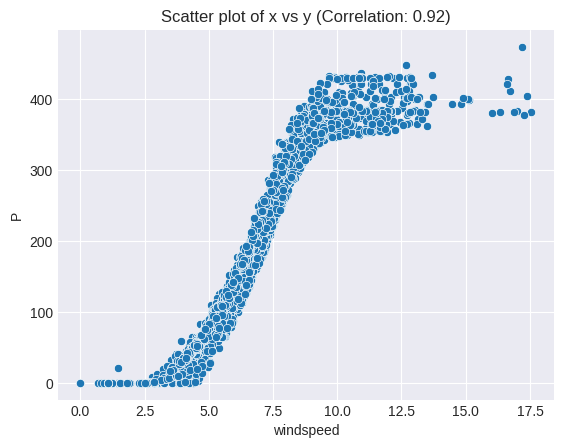

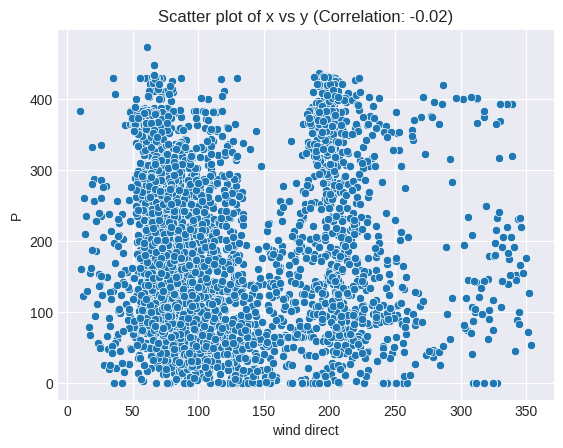

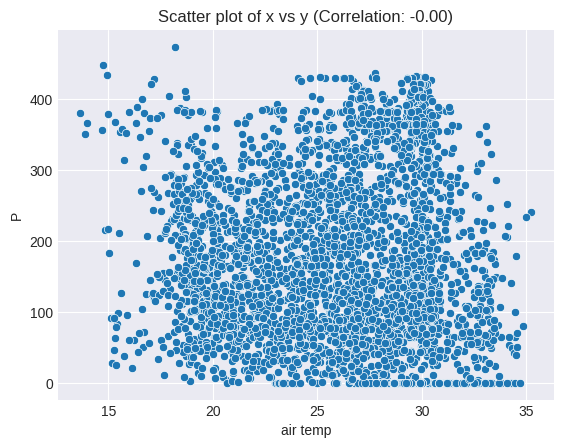

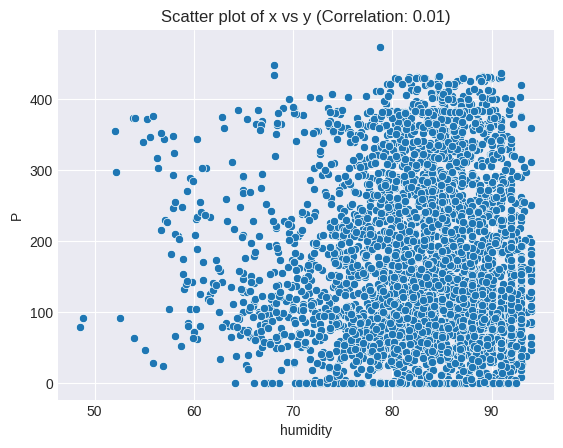

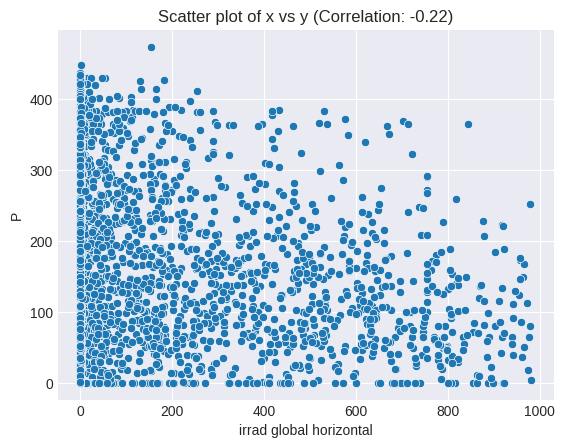

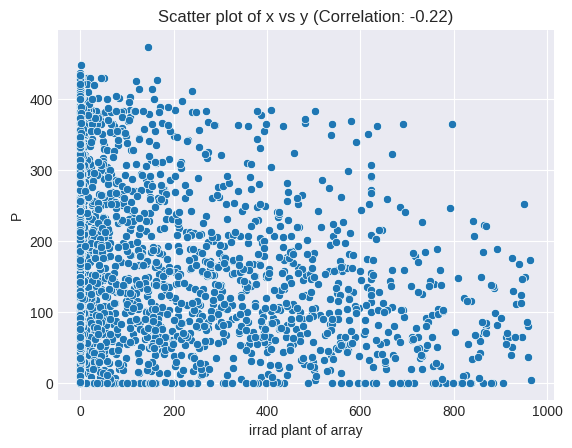

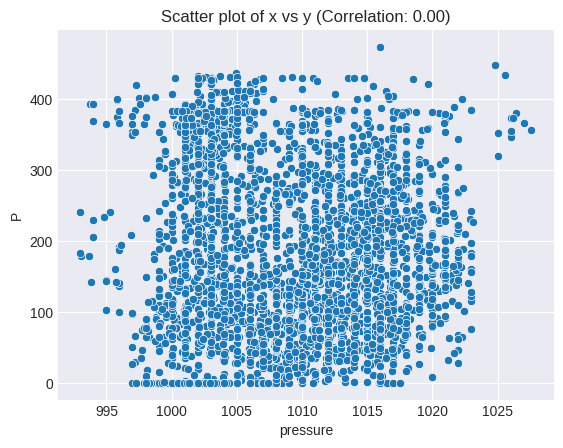

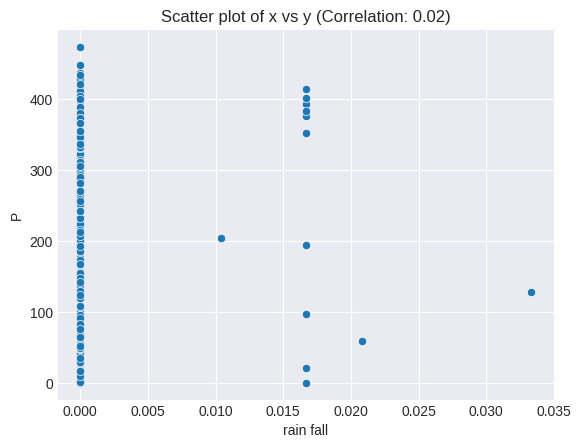

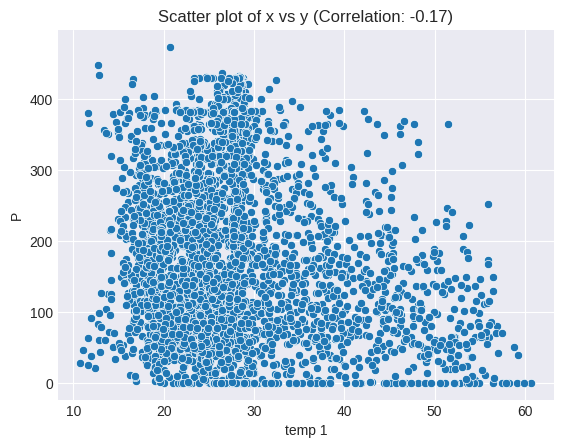

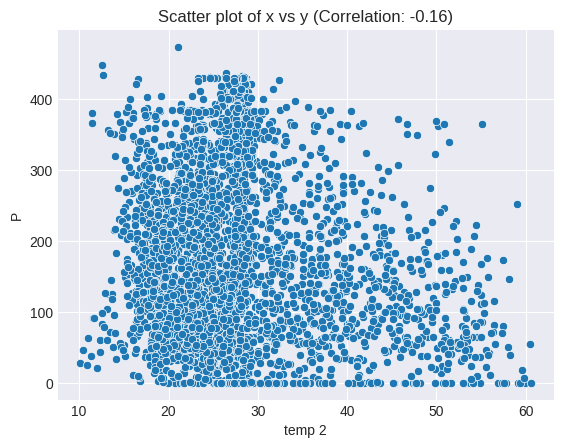

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning:

invalid value encountered in divide



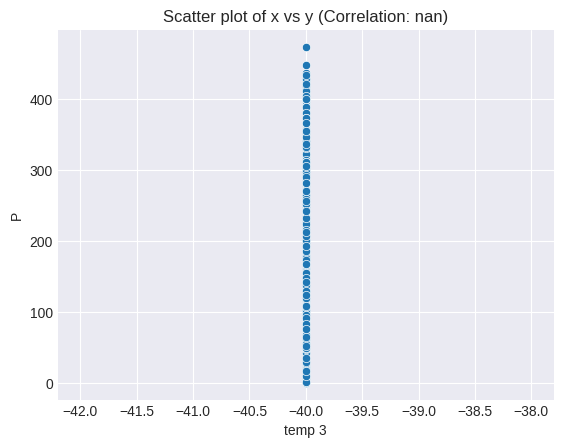

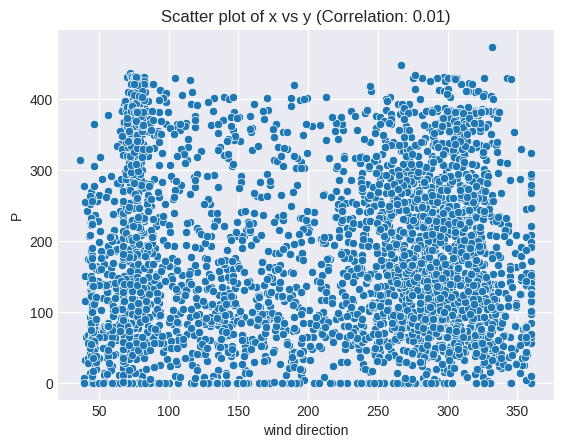

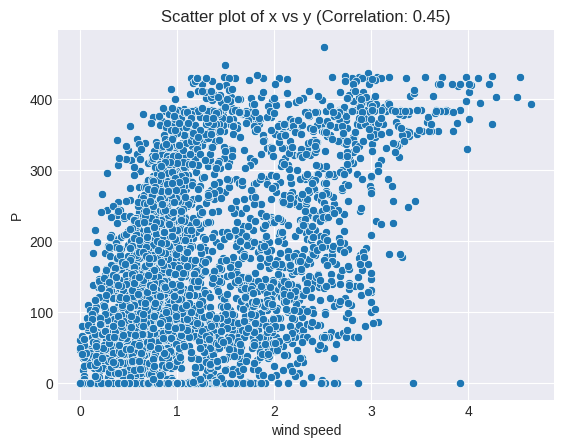

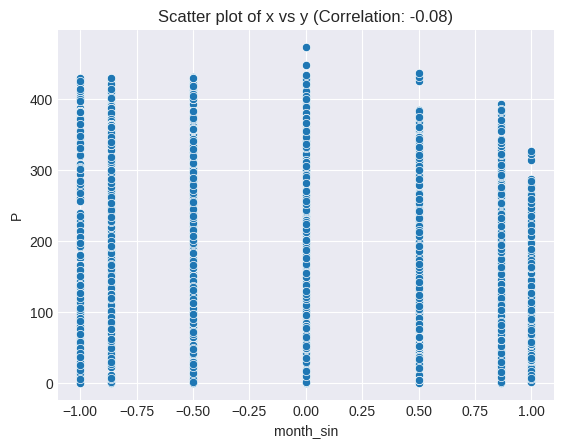

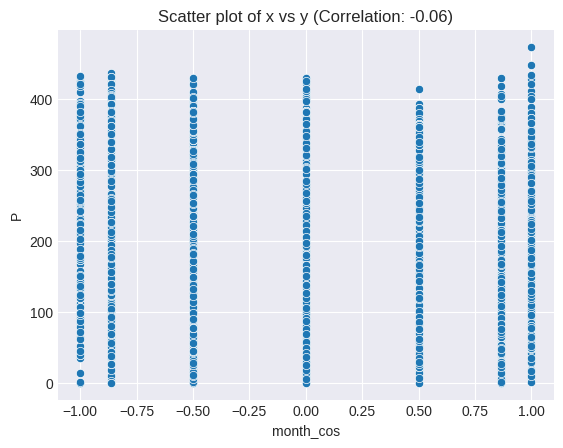

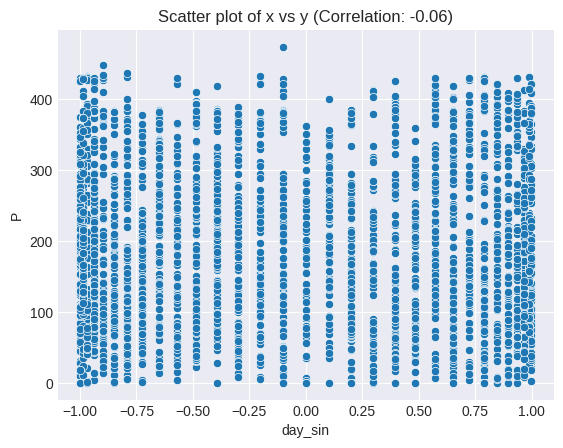

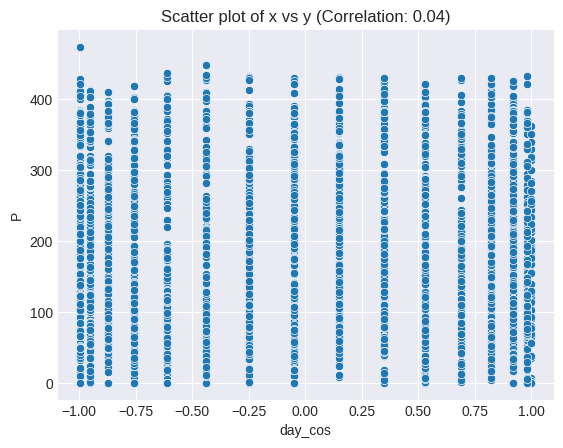

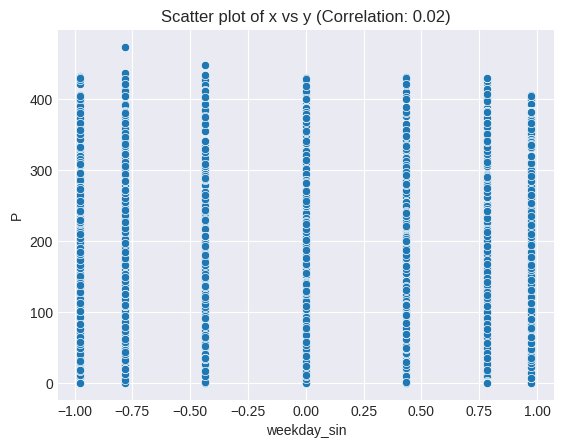

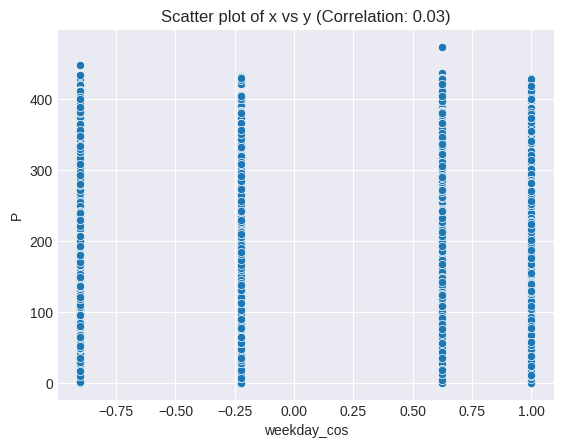

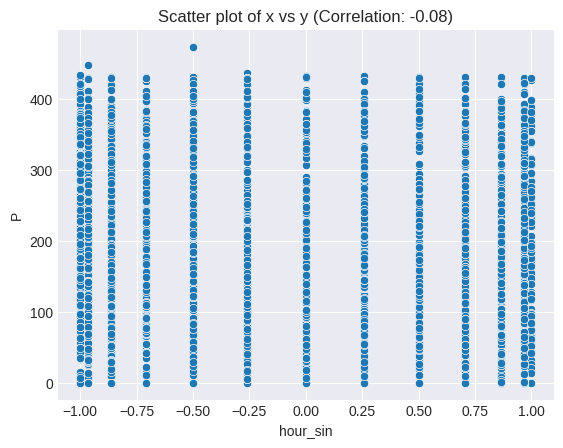

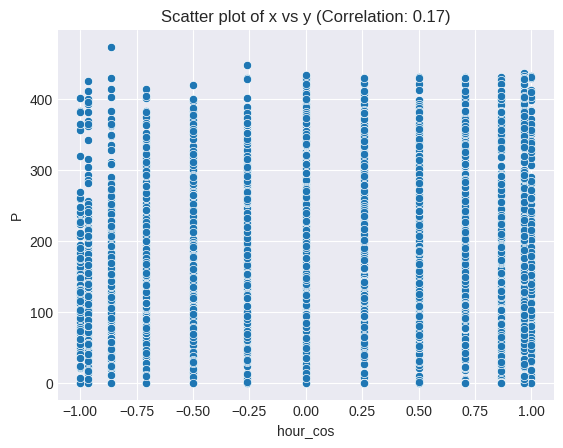

['windspeed', 'wind speed']
time: 4.34 s (started: 2025-05-19 09:22:19 +00:00)


In [8]:
target = 'P'
fe =[]
print("*************************************************************************")
print("**********************************"+target+"********************************")
print("*************************************************************************")
for i in exog_features:
    correlation = data[target].corr(data[i])
    # Vẽ biểu đồ
    sns.scatterplot(data=data, y=target, x=i)
    # Đặt tiêu đề với hệ số tương quan
    plt.title(f'Scatter plot of x vs y (Correlation: {correlation:.2f})')
    if abs(correlation)> 0.25: fe.append(i)
    plt.show()
print(fe)

# All

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
# Original split with ID tracking
X = data[exog_features]  # Exclude ID here for training and prediction
y = data["P"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=2529)

# Resetting index to avoid misalignment after splitting
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

time: 7.56 ms (started: 2025-05-19 10:18:04 +00:00)


In [11]:
start_time = time.time()

search_spaces = {
    'learning_rate': Real(0.01, 1.0, prior='log-uniform'),
    'max_iter': Integer(100, 1000),
    'max_depth': Integer(3, 10),
    'min_samples_leaf': Integer(1, 10),
    'l2_regularization': Real(1e-9, 10, prior='log-uniform')
}


initial_model = HistGradientBoostingRegressor(loss='squared_error', random_state=42)
initial_model.fit(X_train, y_train)
# Regressor hyperparameters search space
n_splits = 5  # Number of splits for cross-validation
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)
opt = BayesSearchCV(
    estimator=initial_model,
    search_spaces=search_spaces,
    n_iter=100,
    scoring=make_scorer(mean_absolute_error, greater_is_better=False),
    random_state=42,
    cv= cv_strategy  # This is a custom cv strategy that only uses test data
)
# Tiến hành tối ưu hóa
opt.fit(X_train, y_train)

# Kết quả
print("Best parameters found: ", opt.best_params_)
print("Best cross-validation score: ", opt.best_score_)
end_time = time.time()
turning_time = end_time - start_time
print(turning_time)

Best parameters found:  OrderedDict([('l2_regularization', 1e-09), ('learning_rate', 0.03374325776442138), ('max_depth', 10), ('max_iter', 953), ('min_samples_leaf', 1)])
Best cross-validation score:  -10.78767212995957
2033.108097076416
time: 33min 53s (started: 2025-05-19 09:42:35 +00:00)


In [15]:
best_model = HistGradientBoostingRegressor(**opt.best_params_)
best_model.fit(X_train, y_train)
start_time = time.time()
# Predict on the test set
y_test_pred = opt.predict(X_test)
y_test_pred2 = best_model.predict(X_test)
end_time = time.time()
test_time = end_time - start_time
print(test_time)
# Evaluate using Mean Absolute Error (or another metric)
test_score = mean_absolute_error(y_test, y_test_pred)
print("Validation set mean absolute error:", test_score)

print(np.mean(y_test))
print(np.mean(y_test_pred))
print(np.mean(y_test_pred2))

0.13869190216064453
Validation set mean absolute error: 11.002054844735628
169.46740657644824
169.80096871840428
169.80096871840428
time: 5.87 s (started: 2025-05-19 10:18:06 +00:00)


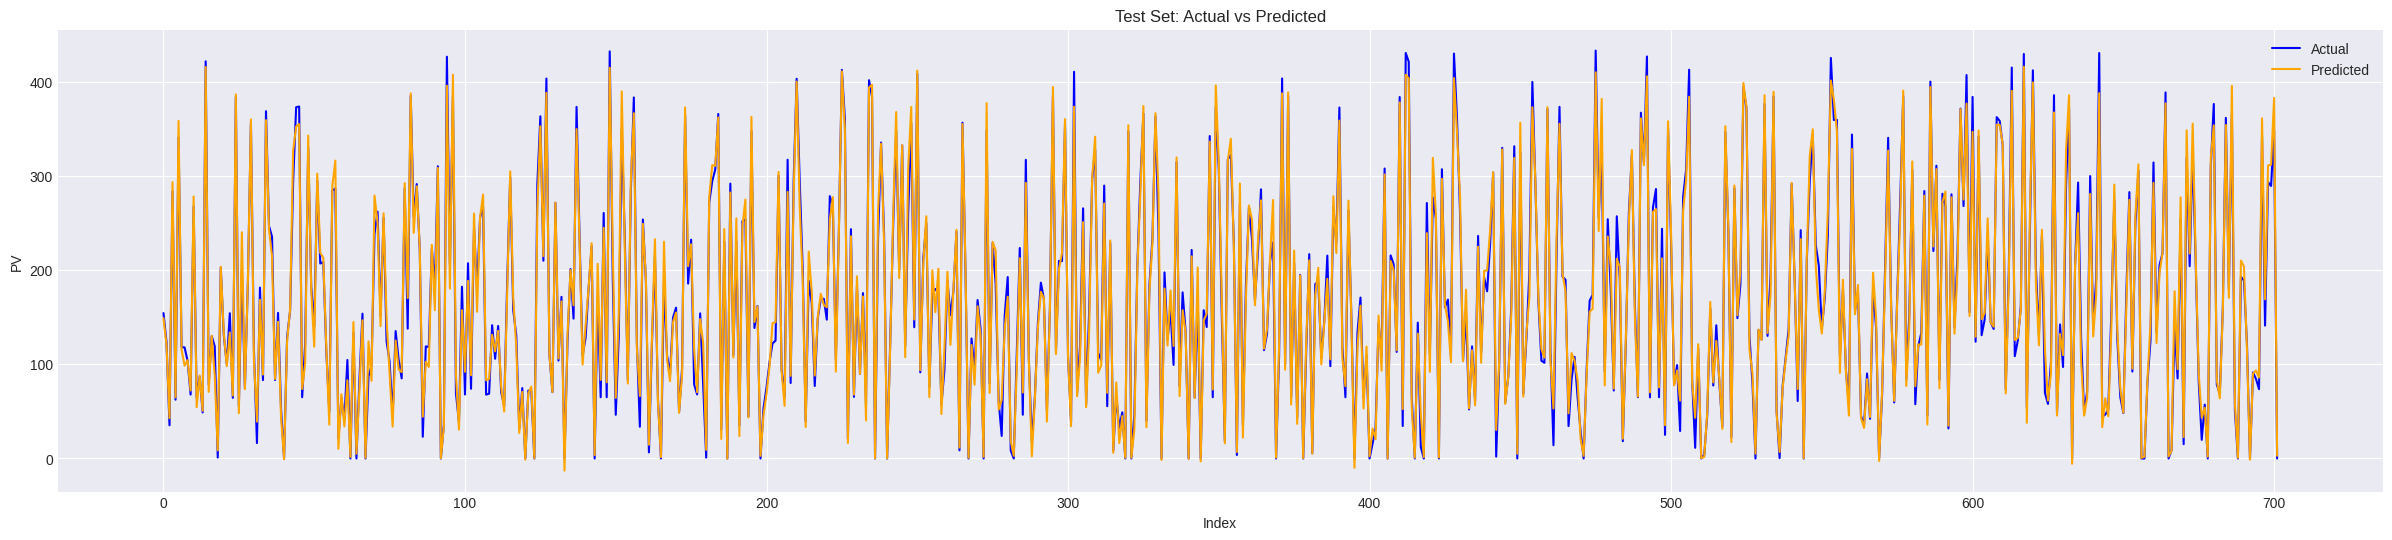

time: 977 ms (started: 2025-05-19 10:18:26 +00:00)


In [16]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# Assuming y_val and y_val_pred have the same index for easy plotting
y_test_series = pd.Series(y_test, index=y_test.index)  # Ensure y_val is a Series with the correct index

# Plot the actual vs predicted values
plt.figure(figsize=(30, 6))
plt.plot(y_test_series.index, y_test_series, label='Actual', color='b')
plt.plot(y_test_series.index, y_test_pred2, label='Predicted', color='orange')
plt.xlabel('Index')
plt.ylabel('PV')
plt.title('Test Set: Actual vs Predicted')
plt.legend()
plt.show()

In [17]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# Test error
# ==============================================================================
y_true = y_test
y_pred = y_test_pred2
#y_pred = y_pred.values.reshape(-1)

# Tính MSE và MAE
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

# Tính MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100 #lỗi do y_true có gtri = 0

# Tính Relative MAE (rel_mae)
mean_actual = np.mean(y_true)
rel_mae = 100 * (mae / mean_actual)
rel_rmse = 100 * (rmse / mean_actual)


# Hiển thị các kết quả
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}%')
print(f'Relative MAE: {rel_mae}%')
print(f'Relative RMSE: {rel_rmse}%')

MSE: 216.47546604548864
RMSE: 14.713105248229846
MAE: 11.002054844735628
MAPE: inf%
Relative MAE: 6.492136197158659%
Relative RMSE: 8.681967550847386%
time: 22.8 ms (started: 2025-05-19 10:18:29 +00:00)


In [18]:
import pickle
from google.colab import drive
drive.mount('/content/drive')
model_path = '/content/drive/MyDrive/19_5/HistGradientBoosting_wind_all_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)

Mounted at /content/drive
time: 21.2 s (started: 2025-05-19 10:21:00 +00:00)


In [19]:
import pickle
from google.colab import drive
drive.mount('/content/drive')
train_time = turning_time
save_data = {'MSE': mse, 'MAE' : mae,'RMSE' : rmse, 'Relative MAE' : rel_mae, 'Relative RMSE' : rel_rmse, 'train time' : train_time, 'test time' :test_time}

with open('/content/drive/MyDrive/19_5/wind_HistGradientBoosting_all.pkl', 'wb') as f:
  pickle.dump(save_data, f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 1.38 s (started: 2025-05-19 10:21:24 +00:00)


# Selected

In [21]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
# Original split with ID tracking
X = data[fe]  # Exclude ID here for training and prediction
y = data["P"]

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=2529)

# Resetting index to avoid misalignment after splitting
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

time: 6.52 ms (started: 2025-05-19 10:28:52 +00:00)


In [22]:
start_time = time.time()

search_spaces = {
    'learning_rate': Real(0.01, 1.0, prior='log-uniform'),
    'max_iter': Integer(100, 1000),
    'max_depth': Integer(3, 10),
    'min_samples_leaf': Integer(1, 10),
    'l2_regularization': Real(1e-9, 10, prior='log-uniform')
}


initial_model = HistGradientBoostingRegressor(loss='squared_error', random_state=42)
initial_model.fit(X_train, y_train)
# Regressor hyperparameters search space
n_splits = 5  # Number of splits for cross-validation
cv_strategy = KFold(n_splits=5, shuffle=True, random_state=42)
opt = BayesSearchCV(
    estimator=initial_model,
    search_spaces=search_spaces,
    n_iter=100,
    scoring=make_scorer(mean_absolute_error, greater_is_better=False),
    random_state=42,
    cv= cv_strategy  # This is a custom cv strategy that only uses test data
)
# Tiến hành tối ưu hóa
opt.fit(X_train, y_train)

# Kết quả
print("Best parameters found: ", opt.best_params_)
print("Best cross-validation score: ", opt.best_score_)
end_time = time.time()
turning_time = end_time - start_time
print(turning_time)

Best parameters found:  OrderedDict([('l2_regularization', 10.0), ('learning_rate', 0.020655071022630048), ('max_depth', 7), ('max_iter', 276), ('min_samples_leaf', 5)])
Best cross-validation score:  -12.648198699884155
838.537999868393
time: 13min 58s (started: 2025-05-19 10:29:06 +00:00)


In [23]:
best_model = HistGradientBoostingRegressor(**opt.best_params_)
best_model.fit(X_train, y_train)
start_time = time.time()
# Predict on the test set
y_test_pred = opt.predict(X_test)
y_test_pred2 = best_model.predict(X_test)
end_time = time.time()
test_time = end_time - start_time
print(test_time)
# Evaluate using Mean Absolute Error (or another metric)
test_score = mean_absolute_error(y_test, y_test_pred)
print("Validation set mean absolute error:", test_score)

print(np.mean(y_test))
print(np.mean(y_test_pred))
print(np.mean(y_test_pred2))

0.04827761650085449
Validation set mean absolute error: 13.278068321727956
169.46740657644824
169.77745974055804
169.77745974055804
time: 531 ms (started: 2025-05-19 10:43:05 +00:00)


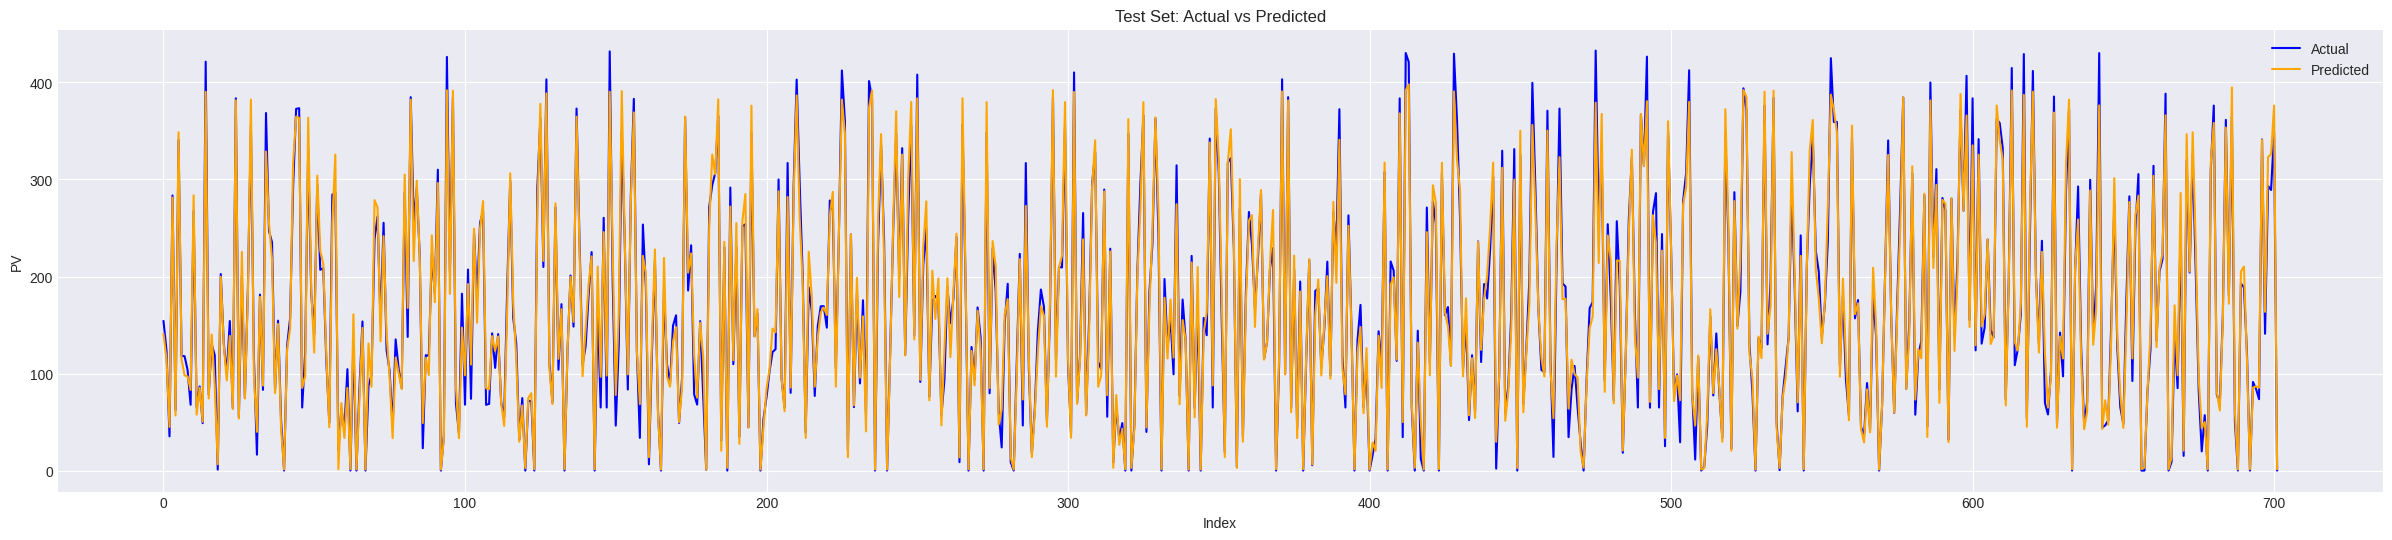

time: 362 ms (started: 2025-05-19 10:43:05 +00:00)


In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.graph_objects as go

# Assuming y_val and y_val_pred have the same index for easy plotting
y_test_series = pd.Series(y_test, index=y_test.index)  # Ensure y_val is a Series with the correct index

# Plot the actual vs predicted values
plt.figure(figsize=(30, 6))
plt.plot(y_test_series.index, y_test_series, label='Actual', color='b')
plt.plot(y_test_series.index, y_test_pred, label='Predicted', color='orange')
plt.xlabel('Index')
plt.ylabel('PV')
plt.title('Test Set: Actual vs Predicted')
plt.legend()
plt.show()

In [25]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
# Test error
# ==============================================================================
y_true = y_test
y_pred = y_test_pred2
#y_pred = y_pred.values.reshape(-1)

# Tính MSE và MAE
mse = mean_squared_error(y_true, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_true, y_pred)

# Tính MAPE
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100 #lỗi do y_true có gtri = 0

# Tính Relative MAE (rel_mae)
mean_actual = np.mean(y_true)
rel_mae = 100 * (mae / mean_actual)
rel_rmse = 100 * (rmse / mean_actual)


# Hiển thị các kết quả
print(f'MSE: {mse}')
print(f'RMSE: {rmse}')
print(f'MAE: {mae}')
print(f'MAPE: {mape}%')
print(f'Relative MAE: {rel_mae}%')
print(f'Relative RMSE: {rel_rmse}%')

MSE: 309.81433456407757
RMSE: 17.601543527886342
MAE: 13.278068321727956
MAPE: inf%
Relative MAE: 7.835175264653679%
Relative RMSE: 10.386388677014498%
time: 5.13 ms (started: 2025-05-19 10:43:06 +00:00)


In [26]:
import pickle
from google.colab import drive
drive.mount('/content/drive')
model_path = '/content/drive/MyDrive/19_5/HistGradientBoosting_wind_selected_model.pkl'
with open(model_path, 'wb') as f:
    pickle.dump(best_model, f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 1.62 s (started: 2025-05-19 10:43:43 +00:00)


In [27]:
import pickle
from google.colab import drive
drive.mount('/content/drive')
train_time = turning_time
save_data = {'MSE': mse, 'MAE' : mae,'RMSE' : rmse, 'Relative MAE' : rel_mae, 'Relative RMSE' : rel_rmse, 'train time' : train_time, 'test time' :test_time}

with open('/content/drive/MyDrive/19_5/wind_HistGradientBoosting_selected.pkl', 'wb') as f:
  pickle.dump(save_data, f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
time: 1.38 s (started: 2025-05-19 10:43:45 +00:00)
